# Image Processing Software Script

Used for nodule detection, feature extraction, and preprocessing the CT scan stack before inputting into the CNN model

Justification for algorithm used is stated in justification and testing script

Sample output is shown using patient ID=1 as a test (data path file is local to my device)

In [1]:
# Import necessary modules and packages
import os
import numpy as np
import pydicom
import cv2
import PIL
import math
import matplotlib.pyplot as plt
from matplotlib import cm
from glob import glob
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from skimage import segmentation
from sklearn.cluster import KMeans

Loading data (all ct scan slices) from patient with id=0001

In [2]:
data_path = "/home/student/Documents/FYP/LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-30178/3000566.000000-03192"
g = glob(data_path + '/*.dcm')

Load all scans into list and converts raw values into Houndsfeld units

In [3]:
def load_scan(path):
    
    scans = []
    for pth, dirs, files in os.walk(path):
        for filename in files:
            if ".dcm" in filename: 
                scans.append(os.path.join(pth,filename))
        
    slices = [pydicom.read_file(s) for s in scans]
    
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

patient = load_scan(data_path)
imgs = get_pixels_hu(patient)

Display stack of ct scans (for user-friendly purposes, just display every 3rd slice)

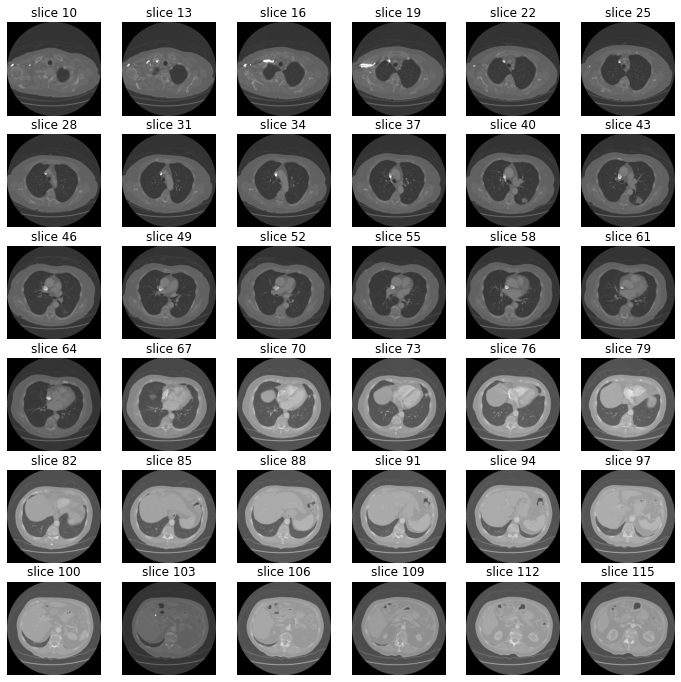

In [4]:
imgs_to_process = imgs

def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=3):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

sample_stack(imgs_to_process)

Function to apply median filter onto image (filtering and removing white noise). Median filter is chosen because it is an edge preserving algorithm (research shows that edge preserving algorithms perform better in nodule detection as opposed to non-edge preserving algorithms such as gaussian blur)

In [5]:
# median filter
def median_filter(img, display=False, footprint=0):
    temp = scipy.ndimage.median_filter(img,2)
    if (display):
        plt.axis('off')
        plt.imshow(temp,cmap='gray')
    return temp

Function used to perform the segmentation algorithm on the CT scan.
Segmentation is used to segment the image and remove all blood vessels and noise, leaving only the lung cavity
and nodules behind.
Segmentation algorithm is done by: 
- Standardize the pixel value by subtracting the mean and dividing by the standard deviation
- Identify the proper threshold by creating 2 KMeans clusters comparing centered on soft tissue/bone vs lung/air.
- Using Erosion and Dilation which has the net effect of removing tiny features like pulmonary vessels or noise

In [6]:
# Segmentation and thresholding
def thresholding(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    #
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))
    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    return dilation

Function used for morphological ACWE evolution, returns just the contour line of the feature found

In [7]:
def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store

def acwe_morph(img, display=False):
    
    init_ls = segmentation.checkerboard_level_set(img.shape, 6)
    evolution = []
    callback = store_evolution_in(evolution)
    ls = segmentation.morphological_chan_vese(img, 35, init_level_set=init_ls, smoothing=3,
                                 iter_callback=callback)

    if display: 
        plt.axis('off')
        plt.imshow(ls, cmap="gray")
        contour = plt.contour(evolution[2], [0.5], colors='g')
        contour.collections[0].set_label("Iteration 2")
        contour = plt.contour(evolution[7], [0.5], colors='y')
        contour.collections[0].set_label("Iteration 7")
        contour = plt.contour(evolution[-1], [0.5], colors='r')
        contour.collections[0].set_label("Iteration 35")
        
    return ls
    

Function used to obtain only the nodules (without the lung cavity) from a scan. After performing the ACWE morphological evolution algorithms, label the different regions of the image, and remove the region of the image that is the lung segment (the lung wall). To remove the lungs cavity, we have to remove the largest surrouding region (because the largest region is the lung wall segment). For each remaining region, extract its features such as area, diameter, solidity and its spiculation. Return the labelled image without the lung wall segment (only getting nodules in the lung), and return the extracted features

In [8]:
def get_nodule(img, display=False, explain=False):
    second_img = img
    second_img = acwe_morph(thresholding(median_filter(second_img)))

    label_img = measure.label(second_img)
    regions = measure.regionprops(label_img)

    if display:
        fig, ax = plt.subplots()
        ax.imshow(label_img)

    im_border = segmentation.clear_border(second_img, buffer_size=5)
    
    if display:
        plt.imshow(im_border)

    label_img = measure.label(im_border)
    regions = measure.regionprops(im_border)
    
    for props in regions:
        equivalent_diameter = props.equivalent_diameter*0.2645833333
        diameter = props.major_axis_length*0.2645833333
        if display:
            print("Area of nodule is (mm^2)" ,props.area*0.2645833333*0.2645833333, "\nDiameter of nodule is (mm)",diameter)
            print("solidity: ", props.solidity)
            print("spiculation: ", diameter-equivalent_diameter)
        if explain:
            spiky = diameter-equivalent_diameter
            area, diam, solid = props.area*0.2645833333*0.2645833333, diameter, props.solidity
            return im_border, area, diam, solid, spiky
            
    
    return im_border

Function used to highlight the nodule found on the original CT scan (for user friendly purposes, easier for the user to see which part of the lung is the detected nodule)

In [9]:
def show_nodules(img, new_img, display=False): 
    
    contours = measure.find_contours(new_img, 0.8)
    
    fig, ax = plt.subplots()
    ax.imshow(img, cmap=plt.cm.gray)

    for n, contour in enumerate(contours):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1.75, color='red')
    
    if display:
        ax.set_xticks([])
        ax.set_yticks([])
        plt.show()
    else:
        return plt

Function used to preprocess the a single scan for the purposes of the CNN. Preprocess the scan such that it will remove the lung and only return regions of the image that are determined to be nodules (size smaller than 20000 pixels and has solidity of >0.9). For every region found (in the case that there is more than one nodule) that meets this criteria, obtain the coordinates of this region, and keep the maximum x,y and minimum x,y coordinates of the region.

In [10]:
def cnn_process(second_img):
    
    label_img = measure.label(second_img)
    regions = measure.regionprops(label_img)

    im_border = segmentation.clear_border(second_img, buffer_size=5)

    label_img = measure.label(im_border)
    regions = measure.regionprops(im_border)
    
    area_coords = []
    
    for props in regions:
        if 0 < props.area < 20000 and props.solidity > 0.90:
            area_coords.append(props.coords.tolist())
    
    result = []
       
    for nodule in area_coords:
        max_x = nodule[0][0]
        min_x = nodule[0][0]
        max_y = nodule[0][1]
        min_y = nodule[0][1]

        for x,y in nodule:
            if x < min_x:
                min_x = x
            if x > max_x:
                max_x = x
            if y < min_y:
                min_y = y
            if y > max_y:
                max_y = y
        result.append([max_x, min_x, max_y, min_y])

    
    return result

Helper function to process all the coordinates for every nodule found in a slice

In [11]:
def get_nodule_stack(nodule_coords, img):
    
    img_stack = []
    
    for max_y, min_y, max_x, min_x in nodule_coords:
        
        pad_up = 25 
        pad_down = 25
        pad_left = 25 
        pad_right = 25 
        
        img_stack.append(median_filter(img[min_y - pad_down :max_y + pad_up, min_x - pad_up:max_x +pad_right], False, 1))    
    
    return img_stack

Now, to preprocess the whole stack of CT scans of the single patient (for the cnn input and for displaying in the webapp). Use the same algorithm and flow as before, just that it is now looping through the whole stack. This whole process takes a while (~3-7 minutes depending on stack size). 
Returns only the zoomed-in slices with nodules found, along with its original CT scan

In [12]:
def get_all(imgs_after_resamp):   
    all_nodule_slices = []
    only_nodule_slices = []

    for img in imgs_after_resamp[15:]:
        second_img = acwe_morph(thresholding(median_filter(img)))
        all_nodule_slices.append(second_img)
        nodule_coords = cnn_process(second_img) 
        if len(nodule_coords) > 0:
            img_stack = get_nodule_stack(nodule_coords, img)
            for image in img_stack:
                only_nodule_slices.append([image, img])
                
    return only_nodule_slices

In [13]:
only_nodule_slices = get_all(imgs_to_process)

Function used to run the whole IP algorithm on a specified data path (processing time: around 3-5 minutes, depending on the patient's lung CT scan stack size: the smaller the size of stack, the faster the processing time)

In [14]:
def preprocess_patient(data_path):
    
    patient = load_scan(data_path)
    imgs = get_pixels_hu(patient)

    imgs_to_process = imgs

    only_nodule_slices = get_all(imgs_to_process)
    
    return only_nodule_slices

Display all the zoomed-in nodule slices found in the stack and display how many nodule slices are found

5


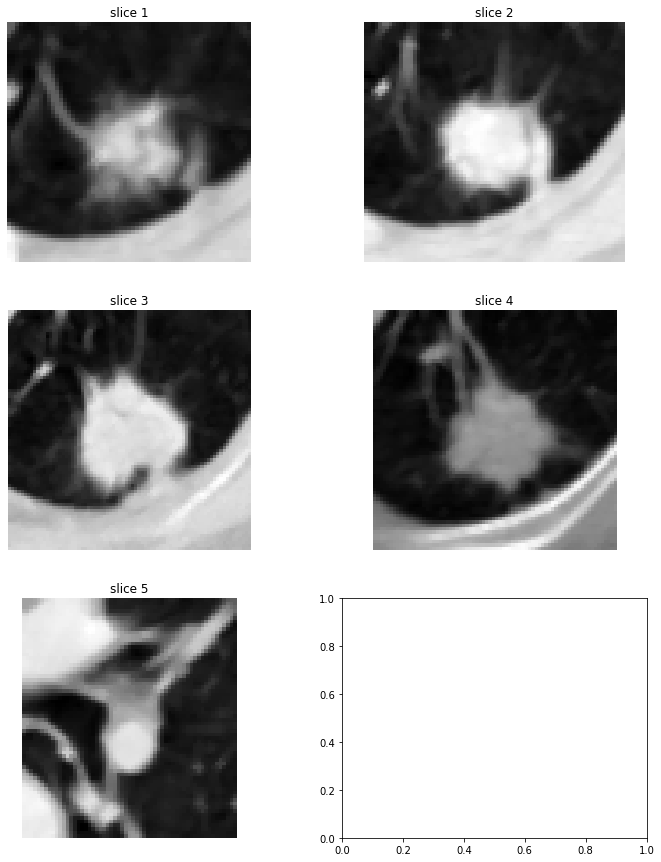

In [15]:
def sample_stack(stack, rows=2):
    size = len(stack)
    if size % 2 == 0:
        cols = size//2
    else: 
        cols = size//2 + 1
    fig,ax = plt.subplots(cols, rows, figsize=[12,15])
    for i in range(rows*cols):
        if i < size:
            ax[int(i/rows),int(i % rows)].set_title('slice %d' % (i+1))
            ax[int(i/rows),int(i % rows)].imshow(stack[i][0],cmap='gray')
            ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

print(len(only_nodule_slices))
sample_stack(only_nodule_slices)

For every slice with a nodule found, display the zoomed-in nodule and the original CT scan, but with the nodule highlighted. This is done by using the previous functions (segmentaion and morphological algorithms)

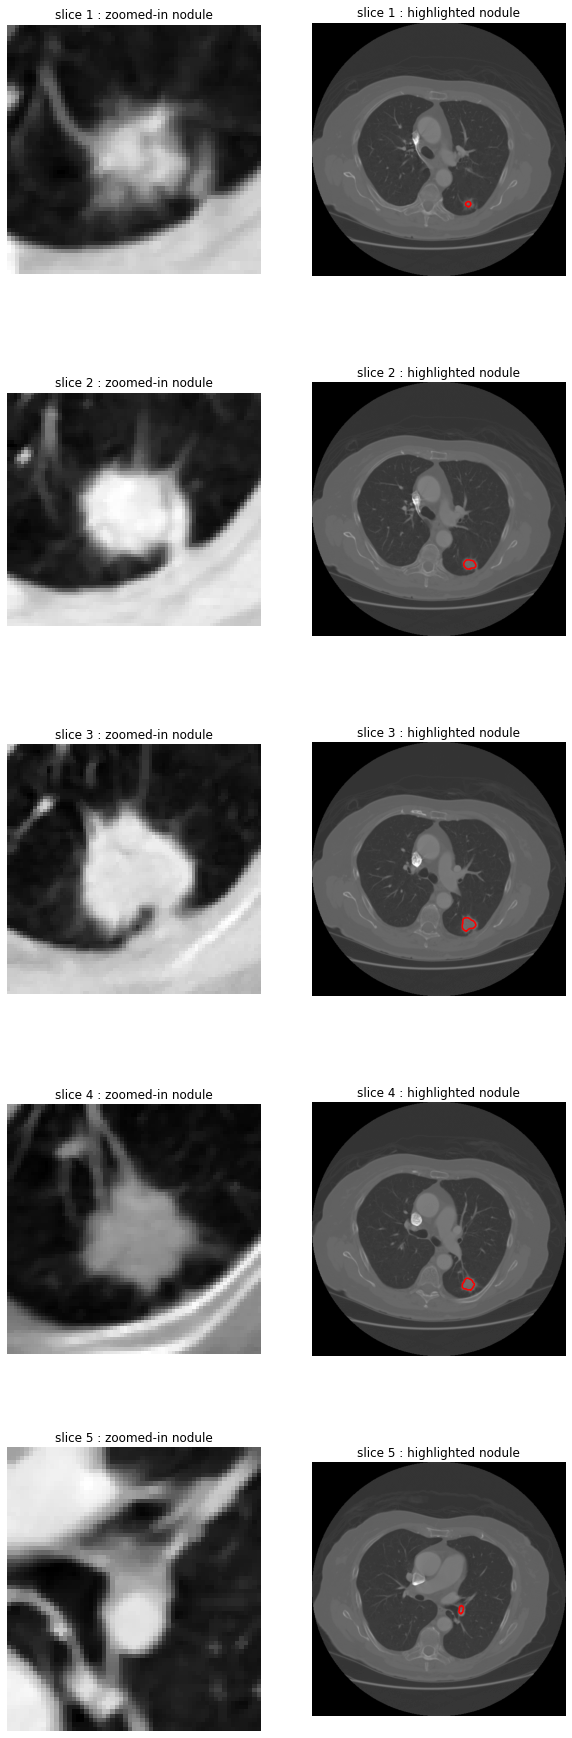

In [16]:
def sample_stack(stack, rows=2):
    
    size = len(stack)

    fig,ax = plt.subplots(size, rows, figsize=[10,32])
    for i in range(size):
        ax[i,0].set_title('slice %d : zoomed-in nodule' % (i+1))
        ax[i,0].imshow(stack[i][0],cmap='gray')
        ax[i,0].axis('off')
        
        new_img = get_nodule(stack[i][1], False)
        contours = measure.find_contours(new_img, 0.8)
        
        ax[i,1].set_title('slice %d : highlighted nodule' % (i+1))
        ax[i,1].imshow(stack[i][1],cmap='gray')
        ax[i,1].axis('off')
        
        for n, contour in enumerate(contours):
            ax[i,1].plot(contour[:, 1], contour[:, 0], linewidth=1.5, color='red')
        
    plt.show()

sample_stack(only_nodule_slices)

Create rule based system, based on the nodule found in the slice, extract the nodule's features from its original image (to preserve its true size and features), and display them. Based on the extracted features, speculate if its malignant or benign

In [17]:
def rule_based(img, i):
    
    zoomed_in = img[0]
    original = img[1]
    
    fig,ax = plt.subplots(1, 2, figsize=[10,40])
    
    ax[0].set_title('slice %d : zoomed-in nodule' % (i+1))
    ax[0].imshow(zoomed_in,cmap='gray')
    ax[0].axis('off')

    new_img, area, diameter, solidity, spiculation= get_nodule(original, False, True)
    contours = measure.find_contours(new_img, 0.8)

    ax[1].set_title('slice %d : highlighted nodule' % (i+1))
    ax[1].imshow(original,cmap='gray')
    ax[1].axis('off')

    for n, contour in enumerate(contours):
        ax[1].plot(contour[:, 1], contour[:, 0], linewidth=1.5, color='red')
        
    plt.show()
    
    if diameter >= 3 and spiculation > 0.1:
        print("Nodule is strongly speculated to be malignant because diameter of nodule >=3mm and its spiculation is spiky")
    else:
        if diameter<3:
            print("Nodule may be malignant because its spiculation is spiky but diameter is <3mm")
        else:
            print("Nodule may be malignant because its diamter is >=3mm but its spiculation is not spiky")
    
    print("Area of Nodule:", area)
    print("Diameter of Nodule:", diameter)
    print("Solidity of Nodule:", solidity)
    print("Spiculation:", spiculation)
    

Sample of rule-based output as shown below (using the last slice of nodule found)

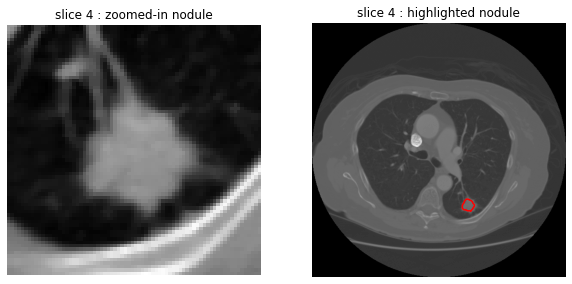

Nodule is strongly speculated to be malignant because diameter of nodule >=3mm and its spiculation is spiky
Area of Nodule: 30.591896693680695
Diameter of Nodule: 6.344841652714308
Solidity of Nodule: 0.9604395604395605
Spiculation: 0.10378303907774455


In [18]:
rule_based(only_nodule_slices[3], 3)